In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

Dataset: https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.tensorflow.org%2Fdatasets%2Fcatalog%2Ffood101

In [5]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteX9JN2U/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteX9JN2U/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
train_ds, valid_ds = ds["train"], ds["validation"]

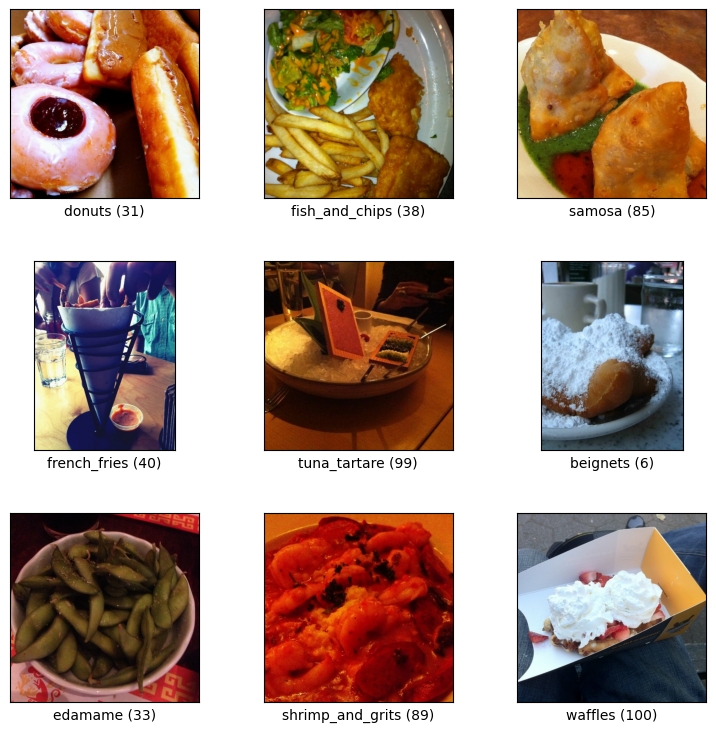

In [7]:
fig = tfds.show_examples(train_ds, ds_info)

In [8]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, (MAX_SIDE_LEN, MAX_SIDE_LEN)), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, (MAX_SIDE_LEN, MAX_SIDE_LEN)), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

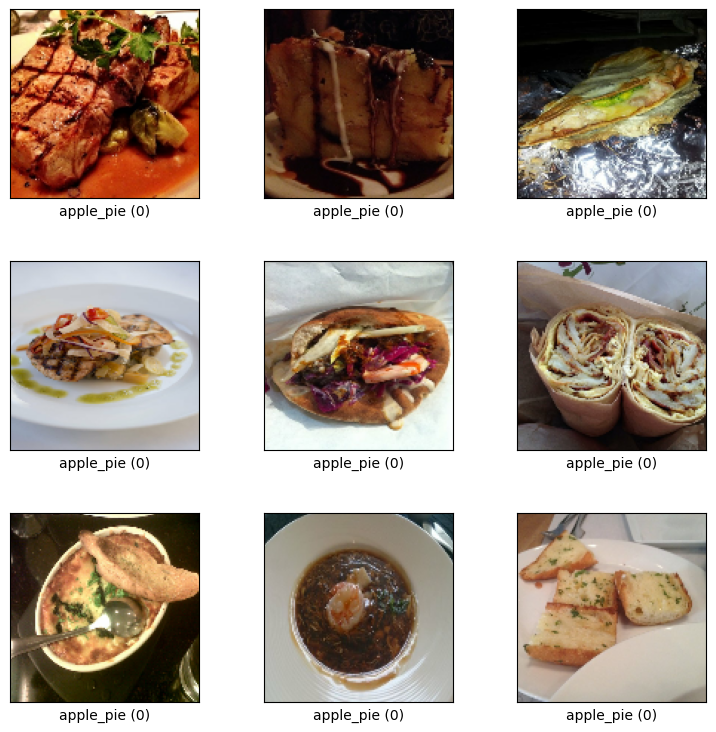

In [9]:
fig = tfds.show_examples(train_ds, ds_info)

In [10]:
training_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [11]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda image, label: label == 0)

data pipeline

In [12]:
batch_size=16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], [0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], [0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  8   9   4]
   [  7   7   5]
   [  7   7   5]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  6   7   2]
   [  7   7   5]
   [ 11  11   9]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [ 12  13   8]
   [ 11  11   9]
   [  9   9   7]]

  ...

  [[ 37  36  47]
   [ 32  33  38]
   [ 40  41  45]
   ...
   [165 174 176]
   [218 228 229]
   [240 250 250]]

  [[ 40  42  49]
   [ 19  21  26]
   [ 27  28  32]
   ...
   [ 98 107 109]
   [126 136 137]
   [168 179 179]]

  [[ 58  62  68]
   [ 43  47  50]
   [ 67  68  70]
   ...
   [171 179 181]
   [202 209 211]
   [ 91  96  99]]]


 [[[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [101 116 123]
   [124 137 145]
   [141 152 156]]

  [[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [ 80  95 102]
   [ 94 107 115]
   [107 118 122]]

  [[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [136 146 147]
   [138 149 153]


# NN implementation

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [15]:
for i,_ in ds["train"].take(1):
  image = i

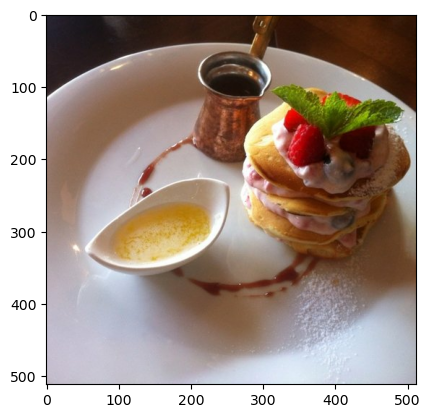

In [16]:
plt.imshow(image)

In [17]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

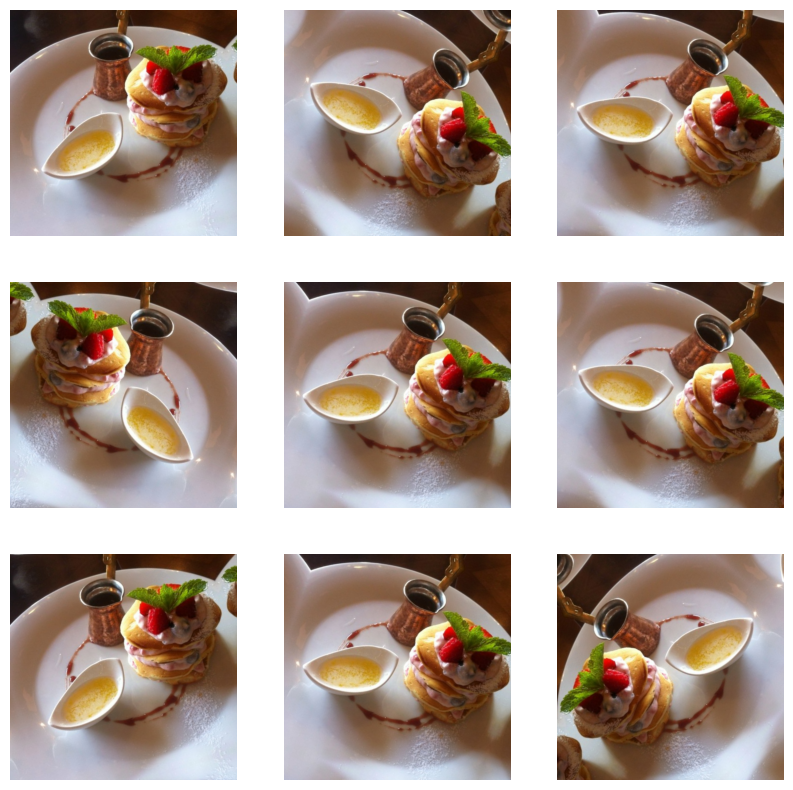

In [18]:
plt.figure(figsize=(10, 10))
for i in range(9):
    aug_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(aug_image[0])
    plt.axis("off")

In [19]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1/.255))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [20]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs = 50
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs, verbose=1)

Epoch 1/50
282/282 [==============================] - 382s 1s/step - loss: 12.6640 - accuracy: 0.5007 - val_loss: 1.7140 - val_accuracy: 0.4980
Epoch 2/50
282/282 [==============================] - 149s 529ms/step - loss: 1.6992 - accuracy: 0.4982 - val_loss: 1.6745 - val_accuracy: 0.4967
Epoch 3/50
282/282 [==============================] - 142s 505ms/step - loss: 1.6664 - accuracy: 0.5000 - val_loss: 1.6433 - val_accuracy: 0.4940
Epoch 4/50
282/282 [==============================] - 148s 524ms/step - loss: 1.6140 - accuracy: 0.5002 - val_loss: 1.5947 - val_accuracy: 0.4967
Epoch 5/50
282/282 [==============================] - 145s 514ms/step - loss: 1.5753 - accuracy: 0.5002 - val_loss: 1.5580 - val_accuracy: 0.4980
Epoch 6/50
282/282 [==============================] - 154s 546ms/step - loss: 1.5415 - accuracy: 0.4993 - val_loss: 1.5248 - val_accuracy: 0.4987
Epoch 7/50
282/282 [==============================] - 142s 504ms/step - loss: 1.5087 - accuracy: 0.5002 - val_loss: 1.4931 - v

In [22]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
    images = image_batch
    labels = label_batch

<Figure size 1000x1000 with 0 Axes>

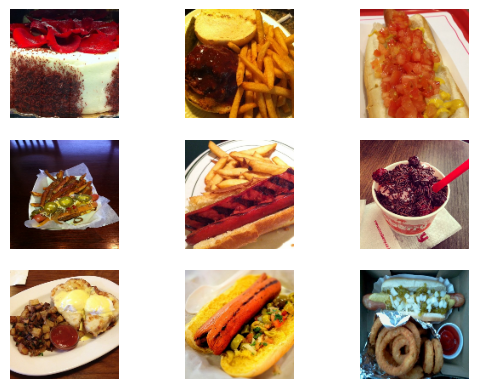

In [23]:
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis("off")

In [24]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 1, 1, 1, 0, 0, 1, 1], dtype=int32)>